# **Parkinson's Disease Detection**


## **Creating Directories**

_In this section, I set up the directories for training, validation, and test datasets. And also define paths to the original datasets for each condition._


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import shutil


def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


base_dir = "./data/input/parkinsons_dataset"
normal_dir = os.path.join(base_dir, "normal")
parkinsons_dir = os.path.join(base_dir, "parkinsons")

# Create train, validation and test directories
output_base_dir = "./data/working/processed_data"
train_dir = os.path.join(output_base_dir, "train")
val_dir = os.path.join(output_base_dir, "val")
test_dir = os.path.join(output_base_dir, "test")

for category in ["Normal", "Parkinson"]:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

## **Preprocessing Function**


In [ ]:
# Function to preprocess images
def preprocess_images(SOURCE, DEST, target_size=(224, 224)):
    for filename in os.listdir(SOURCE):
        img_path = os.path.join(SOURCE, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, target_size)
            img = img / 255.0  # Normalize to [0, 1]
            dest_img_path = os.path.join(DEST, filename)
            cv2.imwrite(dest_img_path, img * 255)  # Save the preprocessed image

## **Splitting and Preprocessing**

_This part includes splitting the data into training, validation, and test sets. It also preprocesses the images by calling the preprocessing function defined earlier._


Visualizing images from Normal


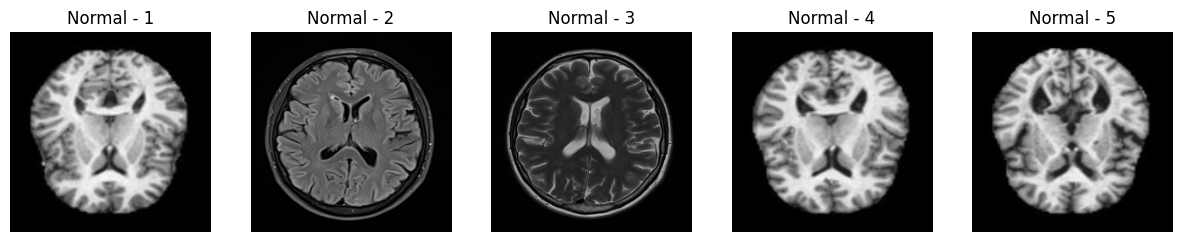

Visualizing images from Alzheimers


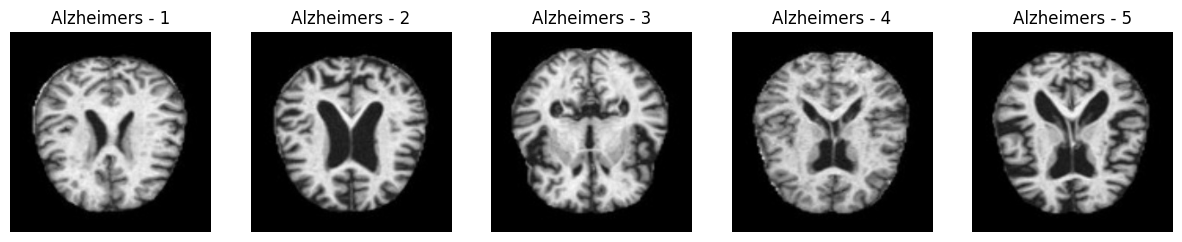

Visualizing images from Parkinson


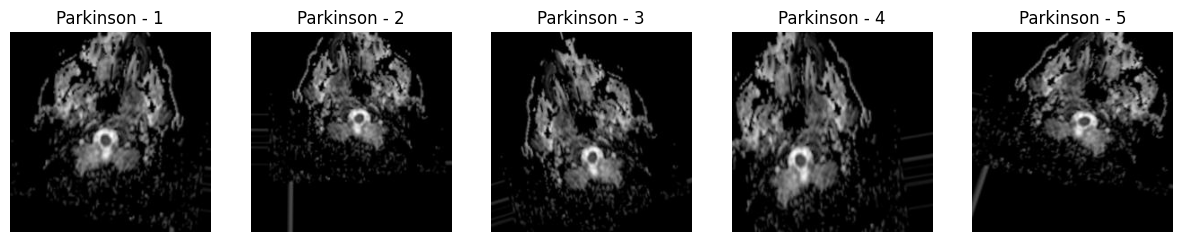

Data preprocessing and splitting completed.


In [ ]:
# Process each category
for category, source_dir in [("Normal", normal_dir), ("Parkinson", parkinsons_dir)]:
    train_dest = os.path.join(train_dir, category)
    val_dest = os.path.join(val_dir, category)
    test_dest = os.path.join(test_dir, category)

    split_data(source_dir, train_dest, val_dest, test_dest)
    preprocess_images(train_dest, train_dest)
    preprocess_images(val_dest, val_dest)
    preprocess_images(test_dest, test_dest)

    # Visualize sample images
    print(f"Visualizing images from {category}")
    visualize_images(category, train_dest)

print("Data preprocessing and splitting completed.")

## **Data Augmentation and Normalization**

_I set up data augmentation and normalization using Keras' ImageDataGenerator to improve the model's robustness by applying random transformations to the training images._


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to the processed data directories
train_dir = "/kaggle/working/processed_data/train"
val_dir = "/kaggle/working/processed_data/validation"
test_dir = "/kaggle/working/processed_data/test"

# Data augmentation and normalization
# Augmentation helps improve the model's robustness by randomly transforming images during training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom into images
    horizontal_flip=True,  # Randomly flip images horizontally
    rotation_range=20,  # New augmentation: Rotate images
    width_shift_range=0.2,  # New augmentation: Shift images horizontally
    height_shift_range=0.2,  # New augmentation: Shift images vertically
    brightness_range=[0.8, 1.2],  # New augmentation: Adjust brightness
)

# Only normalization is applied to validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32,  # Number of images to process in a batch
    class_mode="categorical",  # Use categorical labels (one-hot encoding)
)

validation_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode="categorical")

2024-05-28 06:49:52.449669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 06:49:52.449780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 06:49:52.567312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5311 images belonging to 3 classes.
Found 1139 images belonging to 3 classes.


In [ ]:
# Check if GPU is available
physical_devices = tf.config.list_physical_devices("GPU")
if physical_devices:
    print(f"Using GPU: {physical_devices[0]}")
else:
    print("No GPU found. Using CPU.")

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## **Modifying Pre-trained VGG16 Model**

_I load the pre-trained VGG16 model, add custom layers for this classification task, and compile the model with a lower learning rate._


In [ ]:
# Load the VGG16 model pre-trained on ImageNet, excluding the top layer
# VGG16 is a well-known CNN architecture that has been trained on millions of images from ImageNet
# Using a pre-trained model allows us to leverage learned features from a large dataset, making our model more effective
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for our specific task
x = base_model.output
x = Flatten()(x)  # Flatten the output to a 1D tensor
x = Dense(1024, activation="relu")(x)  # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
predictions = Dense(3, activation="softmax")(x)  # Output layer with 3 neurons (for 3 classes) and softmax activation

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to retain pre-trained weights during initial training
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## **Early Stopping and Training**

_I set up early stopping to prevent overfitting and train the model with the specified training and validation data generators._

## **Model Evaluation and Saving**

_I evaluate the model on the test set, print the test accuracy, and save the trained model for future use._


In [ ]:
# Early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=35,  # Increased epochs for more training time
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping],  # Add early stopping callback
)

# Evaluate the model on the test set
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=64, class_mode="categorical")

evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

# Save the trained model for future use
model.save("/kaggle/working/neurodegenerative_disease_classifier.h5")

Epoch 1/35


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/165 ━━━━━━━━━━━━━━━━━━━━ 1:46:22 39s/step - accuracy: 0.3125 - loss: 1.2912

I0000 00:00:1716879043.565250      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716879043.586725      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/165 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step - accuracy: 0.6842 - loss: 0.6398

W0000 00:00:1716879137.717239      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.6880 - loss: 0.6305

W0000 00:00:1716879140.747512      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


165/165 ━━━━━━━━━━━━━━━━━━━━ 141s 622ms/step - accuracy: 0.6884 - loss: 0.6296 - val_accuracy: 0.8384 - val_loss: 0.3524
Epoch 2/35
  1/165 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.8125 - loss: 0.3033

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1716879166.896752      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.8125 - loss: 0.3033 - val_accuracy: 0.7368 - val_loss: 0.2740
Epoch 3/35
165/165 ━━━━━━━━━━━━━━━━━━━━ 69s 403ms/step - accuracy: 0.8169 - loss: 0.3588 - val_accuracy: 0.8313 - val_loss: 0.3229
Epoch 4/35
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.2092 - val_accuracy: 0.8947 - val_loss: 0.2590
Epoch 5/35
165/165 ━━━━━━━━━━━━━━━━━━━━ 70s 403ms/step - accuracy: 0.8364 - loss: 0.3357 - val_accuracy: 0.8188 - val_loss: 0.4198
Epoch 6/35
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.7500 - loss: 0.5992 - val_accuracy: 0.7368 - val_loss: 0.6677
Epoch 7/35
165/165 ━━━━━━━━━━━━━━━━━━━━ 70s 405ms/step - accuracy: 0.8505 - loss: 0.3065 - val_accuracy: 0.8679 - val_loss: 0.2664
Epoch 8/35
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.8125 - loss: 0.2774 - val_accuracy: 0.8421 - val_loss: 0.3127
Epoch 9/35
165/165 ━━━━━━━━━━━━━━━━━━━━ 70s 406ms/step - accuracy: 0.8691 - loss: 0.2767 - val_accu

W0000 00:00:1716880424.501863      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8971 - loss: 0.2487

W0000 00:00:1716880478.920575      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.8978 - loss: 0.2481
Test Accuracy: 90.35%


## **Plotting Training History**

_I plot the training and validation accuracy and loss values over epochs to visualize the model's performance during training._


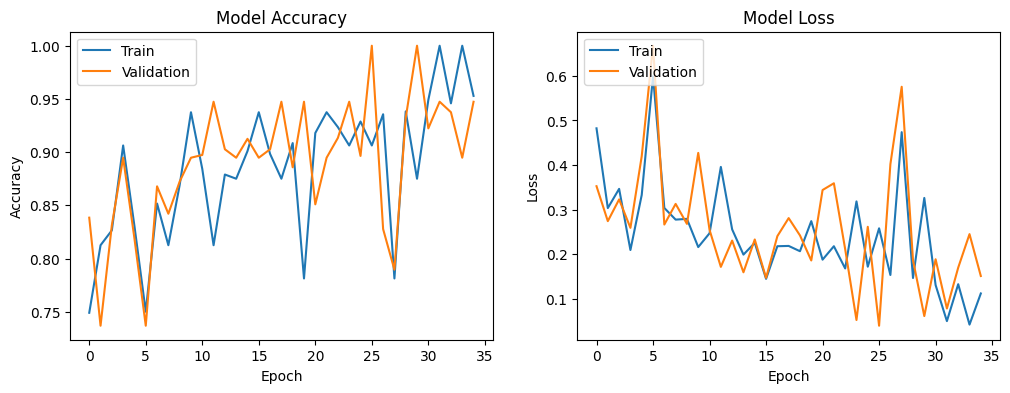

In [ ]:
# Plotting training history
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")

plt.show()

## **Confusion Matrix and Classification Report**

_I generate a confusion matrix and classification report to evaluate the model's performance on the test set, providing detailed metrics for each class._


Found 1140 images belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/36 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step 

W0000 00:00:1716880483.938499      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 727ms/step


W0000 00:00:1716880509.394049      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix


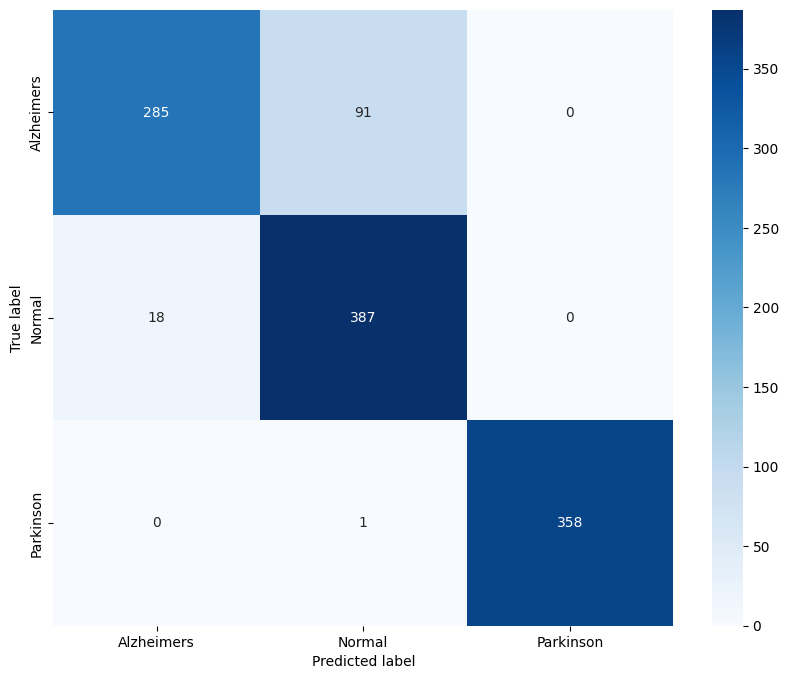

Classification Report
              precision    recall  f1-score   support

  Alzheimers       0.94      0.76      0.84       376
      Normal       0.81      0.96      0.88       405
   Parkinson       1.00      1.00      1.00       359

    accuracy                           0.90      1140
   macro avg       0.92      0.90      0.90      1140
weighted avg       0.91      0.90      0.90      1140



In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False)

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
print("Confusion Matrix")
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# Classification Report
print("Classification Report")
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_403.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/mild_309.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/mild_466.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_1231.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/mild_710.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_474.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_895.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_1379.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_1080.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/mild_96.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_1449.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_13.jpg
/kaggle/input/neurodegenerative-diseases/alzheimers_dataset/verymild_1340.jpg
/kaggle/inpu